In [1]:
import numpy as np
import scipy


def generate_parameters(n=10, max_logit=2, max_count=20, logit_mean=0.1):
    logits = logit_mean + np.random.uniform(-max_logit, max_logit, n)
    probabilities = scipy.special.expit(logits).round(2)
    counts = 1 + np.random.exponential(scale=max_count, size=n).astype(int)
    return probabilities, counts

generate_parameters()

(array([0.25, 0.8 , 0.44, 0.19, 0.46, 0.67, 0.85, 0.76, 0.37, 0.16]),
 array([ 1,  3, 46, 40, 26, 21, 41,  5, 24, 43]))

In [2]:
def generate_experiments(k=1000, **kwargs):
    probabilities, counts = generate_parameters(**kwargs)
    
    target = []
    for p, c in zip(probabilities, counts):
        target.append(
            np.random.binomial(n=c, p=p, size=k)
        )
    target = np.column_stack(target)
    total = np.column_stack([counts] * k).T

    return target, total, probabilities

target, total, probabilities = generate_experiments(1000)

In [3]:
def get_optimal(target, total, probabilities):
    return [np.argmax(probabilities)] * total.shape[0]

np.mean(probabilities[get_optimal(target, total, probabilities)]).round(3)

0.89

In [4]:
def get_argmax(target, total, probabilities):
    return np.argmax(target / total, axis=1)

np.mean(probabilities[get_argmax(target, total, probabilities)]).round(3)

0.826

In [5]:
def get_random(target, total, probabilities):
    return np.random.randint(0, total.shape[1] - 1, total.shape[0])

np.mean(probabilities[get_random(target, total, probabilities)]).round(3)

0.626

In [6]:
strategies = [get_random, get_argmax, get_optimal]

In [67]:
import pandas as pd
from tqdm.auto import tqdm
from joblib import Parallel, delayed, wrap_non_picklable_objects
import itertools
from functools import partial


def check_strategies_once(strategies=[get_random, get_optimal], n_set=[10, 100, 1000], **kwargs):
    results = []

    for n in n_set:
        target, total, probabilities = generate_experiments(n=n, **kwargs)
        experiment_result = {'n': n}

        for strategy in strategies:
            name = ''
            try:
                name = strategy.__name__
            except AttributeError:
                name = f'{strategy.func.__name__}:{strategy.keywords}'

            score = np.mean(probabilities[strategy(target, total, probabilities)])
            experiment_result[name] = score
        results.append(experiment_result)
    return results

def check_strategies_multi(strategies=[get_random, get_optimal], n_set=[10, 100, 1000], n_repeats=10, **kwargs):
    results = []
    print(n_set)

    results = Parallel(n_jobs=-1, verbose=1)(delayed(check_strategies_once)(
        strategies=strategies, n_set=n_set, **kwargs
    ) for i in tqdm(range(n_repeats)))

    return list(itertools.chain.from_iterable(results))

def get_argmax_std_diff(target, total, probabilities, alpha=1.0):
    p_estimate = target / total
    q_estimate = 1 - p_estimate
    std = p_estimate * (1 - q_estimate) / total
    return np.argmax(p_estimate - std * alpha, axis=1)

strategies = [get_argmax, get_optimal] # get_random
for alpha in np.linspace(0.1, 2.0, 20):
    s = partial(get_argmax_std_diff, alpha=alpha)
    strategies.append(
        s
    )

results = check_strategies_multi(
    strategies=strategies, 
    n_set=np.logspace(1, 4, 50).astype(int),
    max_logit=3,
    k=1000,
    n_repeats=80,
)

[   10    11    13    15    17    20    23    26    30    35    40    47
    54    62    71    82    95   109   126   145   167   193   222   255
   294   339   390   449   517   596   686   790   910  1048  1206  1389
  1599  1842  2120  2442  2811  3237  3727  4291  4941  5689  6551  7543
  8685 10000]


  0%|          | 0/80 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.9min


In [ ]:
results.mean(axis=0).T

In [ ]:
results = pd.DataFrame(results).set_index('n').sort_index()
results.sample(3).T

n,17,255,10
get_argmax,0.81534,0.92666,0.89727
get_optimal,0.96000,0.96000,0.94000
get_argmax_std_diff:{'alpha': 0.1},0.89442,0.93518,0.89870
get_argmax_std_diff:{'alpha': 0.2},0.91806,0.93516,0.90403
get_argmax_std_diff:{'alpha': 0.3},0.93541,0.93513,0.90279
get_argmax_std_diff:{'alpha': 0.4},0.94379,0.93535,0.90136
get_argmax_std_diff:{'alpha': 0.5},0.94502,0.93575,0.89944
get_argmax_std_diff:{'alpha': 0.6},0.95156,0.93614,0.89490
get_argmax_std_diff:{'alpha': 0.7},0.95271,0.93645,0.89169
get_argmax_std_diff:{'alpha': 0.7999999999999999},0.95624,0.93742,0.88667


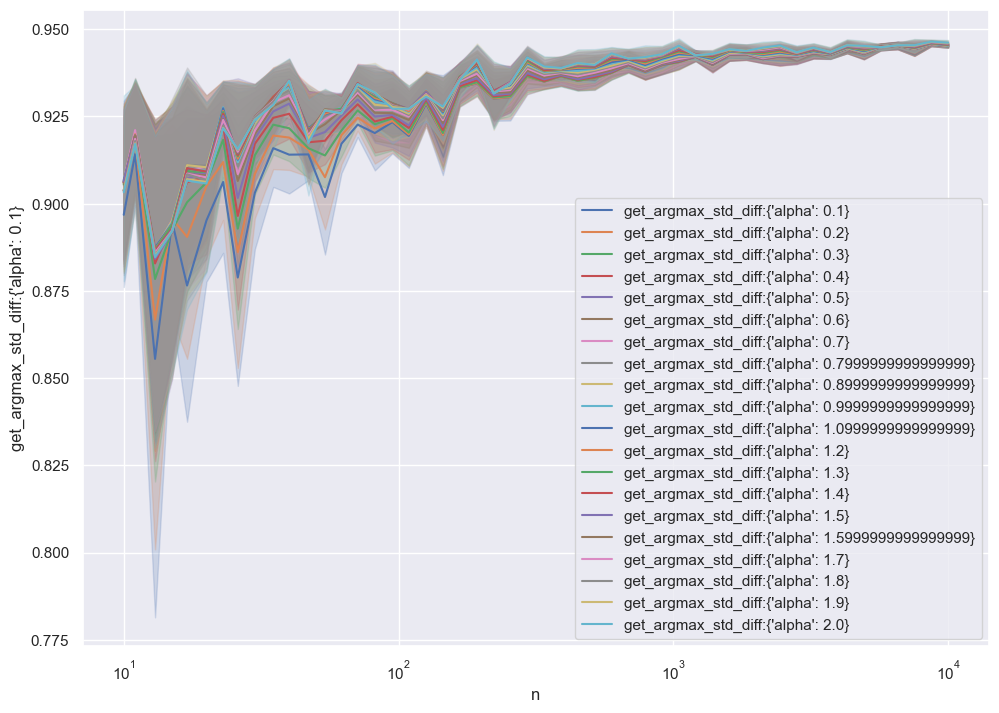

In [ ]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

for strategy_name in results.columns:
    if strategy_name in ['get_optimal', 'get_argmax']:
        continue
    plot = seaborn.lineplot(results, x='n', y=strategy_name, label=strategy_name)
    plot.set(xscale='log')

_ = plt.legend()